# Evaluate the existing topics
Review misspelled words
Calculate Coherance Score

In [20]:
import sys
import os

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    sys.path.append(module_path+"/classes")

review_corpus_path = "../data/tech_review_sent_corpus.pkl"
vocab_path = "../data/glove-tech-revew-vocab.txt"
emb_filename = '../models/w2v_embedding'
aspect_file_path = "../results/aspect.json"
aspect_model_path = "../results/model_param"
vocab_path = "../data/vocab-text-review.txt"
aspect_output_path = '../results/ABAE'
stop_words_path = "../data/stop_words.json"
abae_training_data = "../data/abae_train.pkl"

project_path = ".."

# Create coherance score

In [21]:
import numpy as np
from numpy.random import seed
import tensorflow as tf
seed(76244)
tf.random.set_seed(76244)

import ABAE.utils as U
parser = U.add_common_args()

Using TensorFlow backend.


In [22]:
import pickle
with open(abae_training_data,"rb") as f:
  vocab, train_x, overall_maxlen = pickle.load(f)

vocab_inv = {}
for w, ind in vocab.items():
    vocab_inv[ind] = w

In [23]:
# from datetime import datetime
# from gensim.corpora.dictionary import Dictionary
from scipy.sparse import lil_matrix

vocab_ = np.array([x for x in vocab.keys()])

# X = np.zeros((len(train_x),len(vocab)))
X = lil_matrix((len(train_x),len(vocab)))
for i, review in enumerate(train_x):
    for j in review:
        X[i,j] += 1

print(X.shape)

(148428, 5370)


In [24]:
print(train_x[0])
print(" ".join([vocab_inv[i] for i in train_x[0]]))
print(X[0])

[3, 4, 5, 6, 7]
great people care make difference
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 5)	1.0
  (0, 6)	1.0
  (0, 7)	1.0


In [25]:
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim, metric_coherence_mimno_2011
from keras.models import load_model
from ABAE.my_layers import Attention, Average, WeightedSum, WeightedAspectEmb, MaxMargin
import keras.backend as K
import os

from scipy.spatial.distance import cosine
from itertools import combinations
from scipy.spatial.distance import cosine

def calc_w2v_score(term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( 1 - cosine(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)
    
def calc_score(params):
    k = params[0]
    orth = params[1]
    neg = params[2]
    
    model = load_model(os.path.join(aspect_output_path,"abae-k-{0}-orth-{1}-neg-{2}".format(k,orth,neg)),
                custom_objects={"Attention": Attention, "Average": Average, "WeightedSum": WeightedSum,
                               "MaxMargin": MaxMargin, "WeightedAspectEmb": WeightedAspectEmb,
                               "max_margin_loss": U.max_margin_loss},
                compile=True)
    
    word_emb = K.get_value(model.get_layer('word_emb').embeddings)
    aspect_emb = K.get_value(model.get_layer('aspect_emb').W)
    word_emb = word_emb / np.linalg.norm(word_emb, axis=-1, keepdims=True)
    aspect_emb = aspect_emb / np.linalg.norm(aspect_emb, axis=-1, keepdims=True)
    components = []
    top_vecs = []
    for ind in range(len(aspect_emb)):
        desc = aspect_emb[ind]
        sims = word_emb.dot(desc.T)
        ordered_words = np.argsort(sims)[::-1]
        components.append(sims)
        top_vecs.append([ word_emb[w] for w in ordered_words[:100]])
    

#     score = metric_coherence_gensim(
    mimno_score = metric_coherence_mimno_2011(
#         measure='u_mass', 
        top_n=25, 
        topic_word_distrib=np.array(components), 
        dtm=X,
#         vocab=vocab_,
        return_mean=True
    )
    
    w2v_score = calc_w2v_score(top_vecs)
    
    return k, orth, neg, mimno_score, w2v_score

In [26]:
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool

files = [x for x in os.walk("../results/ABAE")]

params = []
for t in files[0][2]:
    f = t.split("-")
    if (len(f) == 7) & (t[-4:] != 'json'):
        params.append((f[2],f[4],f[6]))

params = list(map(calc_score, tqdm(params)))

100%|██████████| 330/330 [22:27<00:00,  4.08s/it]


In [ ]:
df = pd.DataFrame(params,columns=["k","ortho","neg","mimno","w2v"])
display( df.loc[df.mimno != np.inf, :].sort_values(by="mimno", ascending=False).head(20) )

df.to_csv("../data/ABAE.csv",index=False)

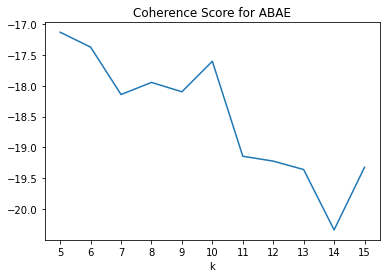

In [4]:
import pandas as pd

df = pd.read_csv("../data/ABAE.csv")
df.groupby(["k"])["mimno"].max().plot(title="Coherence Score for ABAE", xticks=df.k.unique())

## Get List of Words by Topic
Topic Modeling based on K = 10 and Orth = .5.  This gives us best score but most complex words (w2v)

To get topic labels, run `EvaluateABAE.py`, you need to update file with appropiate model

In [7]:
import pickle
from multiprocessing import Pool
from tqdm import tqdm
from ABAE_CreateTrainSet import removeStopWords

with open(review_corpus_path, "rb") as f:
    tech_review_corpus = pickle.load(f)

indices = [review["index"] for review in tech_review_corpus]
reviews = [review["review"] for review in tech_review_corpus]

with Pool() as p:
    reviews = list(tqdm(p.imap(removeStopWords, reviews), total=len(reviews)))

100%|██████████| 148428/148428 [00:06<00:00, 23245.94it/s]


In [9]:
import json

with open("../results/ABAE/abae-k-5-orth-0.1-neg-20-labels.txt") as f:
    labels = f.readlines()

labels = [ int(label.replace("\n","")) for label in labels ]
topics = set(labels)

with open("../results/ABAE/abae-k-5-orth-0.1-neg-20.json", "r") as f:
    aspects_top_n_words = json.load(f)

aspects_reviews = { topic:[] for topic in topics }

for label, review in zip(labels, reviews):
    aspects_reviews[label].append(review)

In [10]:
x = 0
for aspect, corpus in aspects_reviews.items():
    print("Aspect {0} - {1} sentences".format(aspect, len(corpus)))
    x = x + len(corpus)
             
print(x)

Aspect 0 - 22419 sentences
Aspect 1 - 45447 sentences
Aspect 2 - 29590 sentences
Aspect 3 - 24861 sentences
Aspect 4 - 26111 sentences
148428


Create a vocab for each topic

In [11]:
from collections import Counter
from nltk import bigrams

aspects_top_vocab = {}
aspect_top_word_vocab = {}

for aspect, sents in aspects_reviews.items():
    vocab = Counter()
    
    for sent in sents:
        tokens = sent.split(" ")
        bi_grams = bigrams(tokens)
        for token in bi_grams:
            vocab[" ".join(token)] += 1
        
        for token in tokens:
            vocab[token] += 1
    
    aspects_top_vocab[aspect] = ", ".join([ w[0] for w in vocab.most_common(50) ])
    
    aspect_top_word_vocab["Aspect " + str(aspect)] = {word:vocab[str(word)] 
                                                          for word in aspects_top_n_words["Aspect " + str(aspect)]}
        
    
    
    
    
    

In [18]:
topic_names = ["Support","Leadership & Managment","Learning Technology","Work Life Balance","Morale"]
i = 0
for a, words in aspect_top_word_vocab.items():
    print(topic_names[i])
    print(a,words)
    print("\n",aspects_top_vocab[i])
    print("\n")
    i+=1
    
# i = 0
# for a, words in aspects_top_vocab.items():
#     print(topic_names[i])
#     print(a,words)
#     print("\n")
#     i+=1

Support
Aspect 0 {'ticket': 312, 'report': 511, 'log': 122, 'verify': 31, 'file': 134, 'batch': 51, 'manually': 8, 'check': 284, 'document': 237, 'reject': 11, 'monitor': 280, 'confirm': 20, 'release': 201, 'final': 30, 'request': 246, 'submit': 38, 'inspection': 14, 'call': 1232, 'validate': 113, 'checklist': 6, 'upload': 16, 'email': 244, 'paperwork': 13, 'submission': 14, 'deliverable': 152, 'quote': 17, 'send': 125, 'download': 4, 'application': 919, 'dispatch': 17, 'approve': 65, 'scan': 8, 'delete': 5, 'record': 84, 'print': 15, 'queue': 54, 'repair': 78, 'verification': 20, 'order': 220, 'chart': 5, 'paper': 31, 'drawing': 6, 'pre': 7, 'tracking': 24, 'checkpoint': 8, 'packet': 6, 'list': 65, 'folder': 5, 'sheet': 23, 'edit': 13, 'terminal': 11, 'case': 314, 'invoice': 21, 'registering': 7, 'duplicate': 7, 'pending': 14, 'snapshot': 6, 'flight': 3, 'incident': 73, 'server': 576, 'notify': 5, 'cr': 12, 'archive': 6, 'phone': 406, 'backup': 119, 'defect': 116, 'database': 396, 'ac

In [2]:
i = 0
for a, words in aspects_top_vocab.items():
    print(topic_names[i])
    print(a,words)
    print("\n")
    i+=1

NameError: name 'aspects_top_vocab' is not defined

**Review highest Scored sentences**

In [180]:
import numpy as np
from tqdm import tqdm

indices = [review["index"] for review in tech_review_corpus]

with open("../results/ABAE/abae-k-5-orth-0.1-neg-20-topic_weights") as f:
    topic_weights = f.readlines()

topic_weights = [ topic_weight.replace("\n","").split("\t") for topic_weight in tqdm(topic_weights) ]
topic_weights = [ { "aspect "+str(i):float(weight) for i, weight in enumerate(topic_weight) if len(weight) > 0 } for topic_weight in tqdm(topic_weights)]

topic_weights = pd.concat([
                    pd.DataFrame({"review_index":indices, "review":reviews}),
                    pd.DataFrame(topic_weights)
                ], axis=1, ignore_index=False)

topic_weights.head()

100%|██████████| 148428/148428 [00:00<00:00, 264647.78it/s]


,review_index,review,aspect 0,aspect 1,aspect 2,aspect 3,aspect 4
0,299,great people care make difference,0.142151,0.208034,0.215674,0.198882,0.235259
1,299,management care employee well provide continue...,0.127041,0.279404,0.219937,0.119073,0.254545
2,1145,powerhouse epc go heavy worksharing,0.266608,0.163682,0.143910,0.231401,0.194400
3,1145,send much work overseas possible keep core person,0.149226,0.295808,0.154067,0.274678,0.126221
4,1145,heavy load management,0.110048,0.341525,0.172610,0.084236,0.291581


In [181]:
import seaborn as sns
sns.set(style="ticks")


df_stack = topic_weights.iloc[:,range(2,topic_weights.shape[1])].stack().reset_index().rename(columns={0:"weight"})
df_stack.head()

,level_0,level_1,weight
0,0,aspect 0,0.142151
1,0,aspect 1,0.208034
2,0,aspect 2,0.215674
3,0,aspect 3,0.198882
4,0,aspect 4,0.235259


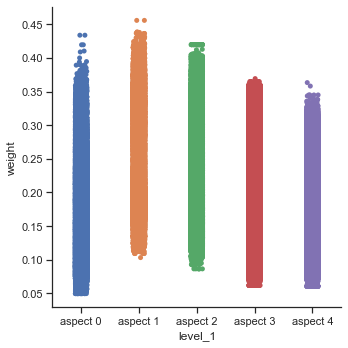

In [182]:
g = sns.catplot(x="level_1", y="weight", data=df_stack)

In [186]:
topic_weights["label"] = topic_weights.iloc[:,range(2,topic_weights.shape[1])].idxmax(axis=1)
topic_weights["weight"] = topic_weights.iloc[:,range(2,topic_weights.shape[1])].max(axis=1)

topic_weights.head()

,review_index,review,aspect 0,aspect 1,aspect 2,aspect 3,aspect 4,label,weight
0,299,great people care make difference,0.142151,0.208034,0.215674,0.198882,0.235259,aspect 4,0.235259
1,299,management care employee well provide continue...,0.127041,0.279404,0.219937,0.119073,0.254545,aspect 1,0.279404
2,1145,powerhouse epc go heavy worksharing,0.266608,0.163682,0.143910,0.231401,0.194400,aspect 0,0.266608
3,1145,send much work overseas possible keep core person,0.149226,0.295808,0.154067,0.274678,0.126221,aspect 1,0.295808
4,1145,heavy load management,0.110048,0.341525,0.172610,0.084236,0.291581,aspect 1,0.341525


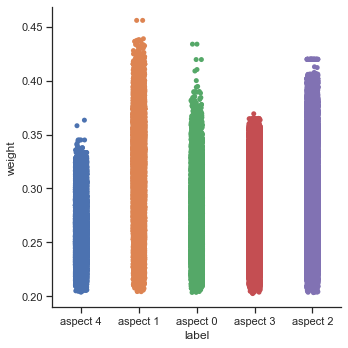

In [187]:
g = sns.catplot(x="label", y="weight", data=topic_weights)

In [188]:
idx = topic_weights.weight >= 0.15
filtered_weights = topic_weights.loc[idx, :]
print(filtered_weights.shape)
filtered_weights.head()

(148428, 9)


,review_index,review,aspect 0,aspect 1,aspect 2,aspect 3,aspect 4,label,weight
0,299,great people care make difference,0.142151,0.208034,0.215674,0.198882,0.235259,aspect 4,0.235259
1,299,management care employee well provide continue...,0.127041,0.279404,0.219937,0.119073,0.254545,aspect 1,0.279404
2,1145,powerhouse epc go heavy worksharing,0.266608,0.163682,0.143910,0.231401,0.194400,aspect 0,0.266608
3,1145,send much work overseas possible keep core person,0.149226,0.295808,0.154067,0.274678,0.126221,aspect 1,0.295808
4,1145,heavy load management,0.110048,0.341525,0.172610,0.084236,0.291581,aspect 1,0.341525


In [189]:
reviews_filtered = filtered_weights.review.tolist()
labels = filtered_weights.label.tolist()

topics = set(labels)

aspects = { topic:[] for topic in topics }

for label, review in zip(labels, reviews_filtered):
    aspects[label].append(review)
    
x = 0
for aspect, corpus in aspects.items():
    print("Aspect {0} - {1} sentences".format(aspect, len(corpus)))
    x = x + len(corpus)
             
print(x)

Aspect aspect 4 - 26111 sentences
Aspect aspect 0 - 22419 sentences
Aspect aspect 2 - 29590 sentences
Aspect aspect 1 - 45447 sentences
Aspect aspect 3 - 24861 sentences
148428


In [190]:
from collections import Counter
from nltk import bigrams

aspects_top_vocab = { "aspect " + str(i): [] for i in range(len(topics))}

for aspect, sents in aspects.items():
    vocab = Counter()
    
    for sent in sents:
        tokens = sent.split(" ")
        bi_grams = bigrams(tokens)
        for token in bi_grams:
            vocab[" ".join(token)] += 1
        
        for token in tokens:
            vocab[token] += 1
    
    aspects_top_vocab[aspect] = [ w[0] for w in vocab.most_common(100) ]

with open("../results/ABAE/abae-k-5-filtered.json", "w") as f:
    json.dump(aspects_top_vocab, f)

In [191]:
i = 0
for a,t in aspects_top_vocab.items():
    print(topic_names[i])
    print(a, t)
    print('\n')
    i+=1

System Support
aspect 0 ['project', 'get', 'time', 'issue', 'customer', 'call', 'system', 'would', 'support', 'use', 'part', 'go', 'job', 'client', 'application', 'process', 'train', 'take', 'development', 'need', 'test', 'good', 'software', 'one', 'make', 'service', 'help', 'provide', 'like', 'year', "n't", 'also', 'hard', 'server', 'user', 'lot', 'end', 'start', 'problem', 'typical', 'meeting', 'every', 'report', 'business', 'review', 'task', 'design', 'requirement', 'many', 'manage', 'give', 'product', 'well', 'code', 'enjoy', 'month', 'implement', 'include', 'involve', 'hard part', 'network', 'activity', 'phone', 'database', 'come', 'work', 'part job', 'daily', 'even', 'know', 'contract', 'base', 'resolve', 'thing', 'complete', 'u', 'create', 'back', 'plan', 'department', 'configure', 'technical', 'fix', 'computer', 'much', 'different', 'could', 'leave', 'always', 'maintain', 'case', 'week', 'ticket', 'hour', 'center', 'troubleshoot', 'handle', 'production', 'write', 'people']


Wo

## POS Tag

In [ ]:
import pickle 
review_corpus_path = "../data/tech_review_sent_corpus.pkl"

with open(review_corpus_path,"rb") as f:
    tech_review_corpus = pickle.load(f)
    
with open("../results/ABAE/abae-k-7-orth-0.75-neg-40-labels.txt") as f:
    labels = f.readlines()

labels = [ int(label.replace("\n","")) for label in labels ]

for label, review in zip(labels, tech_review_corpus):
    review["topic"] = label
    
reviews = [ review["review"] for review in tech_review_corpus ]
topics = [ review["topic"] for review in tech_review_corpus]

In [ ]:
from nltk import pos_tag
from multiprocessing import Pool
from tqdm import tqdm 

with Pool() as p:
    reviews_pos = list(tqdm(p.imap(str.split, reviews), total=len(reviews)))
    reviews_pos = list(tqdm(p.imap(pos_tag, reviews),total=len(reviews_pos)))

In [ ]:
reviews_pos[0]